# Introducing Slope as a Morphological Indicator in a Composite Walkability Index

_The concept of walkability is strongly tied to accessibility. The morphology of the territory — particularly slope — directly affects pedestrian accessibility by influencing how easy it is to move around a neighborhood on foot._


https://doi.org/10.5270/ESA-c5d3d65
European Space Agency (2024). Copernicus Global Digital Elevation Model. Distributed by OpenTopography. 

https://doi.org/10.5069/G9028PQB. Accessed 2025-06-23

## Urban Context – Key Municipalities with Notable Elevation
> This brief overview of Rome’s topographically diverse municipalities is included to provide a **real-world reference** for interpreting the results of the analysis. It helps validate whether the accessibility patterns that emerge are **consistent with the known physical and urban characteristics** of these areas.

### **Municipio XIV**
- Includes **Monte Mario**, the highest hill in Rome (139 meters).
- Contains neighborhoods such as **Balduina**, **Trionfale**, and **Pineta Sacchetti** — all characterized by steep slopes and elevation changes.

### **Municipio XIII**
- Encompasses **Monteverde Vecchio** and the **Gianicolo** hill.
- The **Gianicolo** area features panoramic views and steep descents toward the **Tiber River**.

### **Municipio II**
- Covers the **Parioli** district and **Acqua Acetosa**, areas known for sloping terrain leading down to the river.

### **Municipio I**
- Contains part of the **Historic Center**, including **Trastevere** (particularly the western side of the **Tiber**) and the **Gianicolo** slope.
- The upper part of Trastevere sits on elevated ground.

### **Municipio XV**
- Comprises northern hilly zones such as **Cassia**, **Grottarossa**, and **La Storta**.
- Features rugged and irregular terrain with notable elevation.

### **Giustiniana**  
- A peripheral area in northern Rome, located on the slopes descending from Monte Mario plateau.


In [1]:
import rasterio as rio
from rasterstats import zonal_stats
from rasterio.plot import show

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as PathEffects
import matplotlib.colors as mcolors

import subprocess

import zipfile

from sklearn.preprocessing import MinMaxScaler

import geopandas as gpd
import os 

In [2]:
print(os.getcwd())

/home/dimafra/PycharmProjects/GeospatialProject/notebooks 


In [3]:
# Path zip file
zip_path = "../data/slope_d/output_hh.zip"
# Destination path
extract_to = "../data/slope_d"

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"File extracted in: {extract_to}")


File extracted in: ../data/slope_d


In [4]:
tif_path = '../data/slope_d/output_hh.tif'
with rio.open(tif_path) as src:
        dem = src.read(1)
        profile = src.profile
        
print("Shape:", dem.shape)
print("CRS:", profile["crs"])
print("Resolution:", src.res)
print("Nodata:", src.nodata)

Shape: (5536, 6407)
CRS: EPSG:4326
Resolution: (0.0002777777777777778, 0.0002777777777777778)
Nodata: None


## First DEM visualization of AOI 

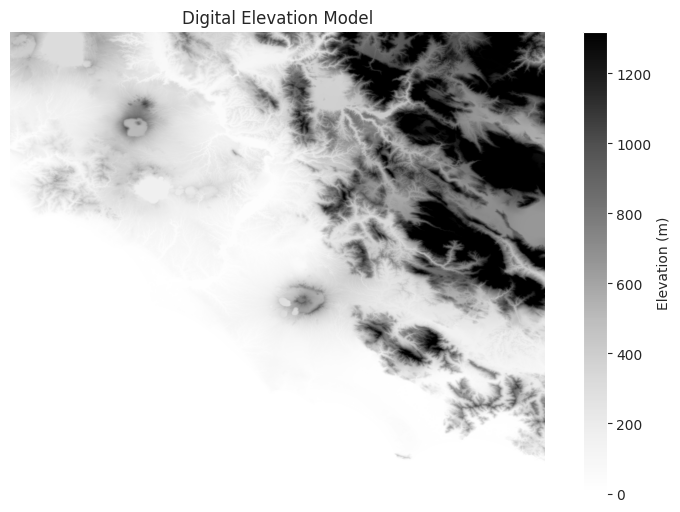

In [5]:
with rio.open(tif_path) as src:
    dem = src.read(1)
    profile = src.profile

dem = np.where(dem == src.nodata, np.nan, dem)

# Stretch (increasing contrast)
vmin = np.nanpercentile(dem, 5)
vmax = np.nanpercentile(dem, 95)

# greys scale visualization 
plt.figure(figsize=(10, 6))
plt.imshow(dem, cmap="Greys", origin="upper", vmin=vmin, vmax=vmax)
plt.colorbar(label="Elevation (m)")
plt.title("Digital Elevation Model")
plt.axis("off")


# Save
#plt.savefig('../output/DEM.png')
plt.show()

## Reprojecting the input DEM to EPSG:25833 (ETRS89 / UTM zone 33N)

 This ensures consistent spatial units (meters) when calculating slope or gradient. The transformation is performed using `gdalwarp` with bilinear resampling to preserve elevation continuity.

In [4]:
dem_25833 = "../data/slope_d/projected_25833.tif"
dst_crs = "EPSG:25833"

cmd = [
    "gdalwarp",
    "-t_srs", dst_crs,
    "-r", "bilinear",    
    "-of", "GTiff",
    tif_path,
    dem_25833
]

subprocess.run(cmd, check=True)
print(f"Reprojection done: {dem_25833}")

ERROR 1: Output dataset ../data/slope_d/projected_25833.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



CalledProcessError: Command '['gdalwarp', '-t_srs', 'EPSG:25833', '-r', 'bilinear', '-of', 'GTiff', '../data/slope_d/output_hh.tif', '../data/slope_d/projected_25833.tif']' returned non-zero exit status 1.

In [5]:
# Reprojected raster details 
with rio.open(dem_25833) as src:
    print("CRS:", src.crs)
    print("Resolution:", src.res)
    print("Bounds:", src.bounds)

CRS: EPSG:25833
Resolution: (26.67061478838572, 26.67061478838572)
Bounds: BoundingBox(left=227547.37098040304, bottom=4552302.083888915, right=379889.92265166226, top=4727101.293211996)


## Slope Calculation using `gdaldem`

This step uses [`gdaldem slope`](https://gdal.org/programs/gdaldem.html) to compute the slope from a reprojected DEM raster in **EPSG:25833**, ensuring that slope calculations are performed in a metric coordinate system.  
The output slope raster is saved as a new **GeoTIFF** file and is expressed in **degrees** by default (use the `-pct` flag to get percentage values instead).

> **Note:** Due to hardware constraints, the `RichDEM` library (optimized for terrain analysis) was not used.  
> Instead, this GDAL-based method provides an accurate and standardized alternative to manual slope calculations, such as those tested using Sobel filters or other custom gradient operations.


In [6]:
# Reading a DEM raster as input and writing a new raster where every pixel now is a slope value
slope_25833 = "../data/slope_d/slope_GDAL_25833.tif"

cmd = [
    "gdaldem",
    "slope",
    dem_25833,
    slope_25833,
    "-of", "GTiff",        # output format
    "-s", "1.0",           # scale factor (1 if X,Y,Z in meters)
    "-compute_edges"       
]

# Add "-pct" to the list above if you want the output to be percentage instead of degrees
subprocess.run(cmd, check=True)
print(f"Slope raster saved to: {slope_25833}")

0...10...20...30...40...50...60...70...80...90...100 - done.
Slope raster saved to: ../data/slope_d/slope_GDAL_25833.tif


In [7]:
slope_4326 = "../data/slope_d/slope_GDAL_4326.tif"

subprocess.run([
    "gdalwarp",
    "-t_srs", "EPSG:4326",
    "-r", "bilinear",
    "-of", "GTiff",
    slope_25833,
    slope_4326
], check=True)

print("✅ Projection in EPSG:4326 completed")

ERROR 1: Output dataset ../data/slope_d/slope_GDAL_4326.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



CalledProcessError: Command '['gdalwarp', '-t_srs', 'EPSG:4326', '-r', 'bilinear', '-of', 'GTiff', '../data/slope_d/slope_GDAL_25833.tif', '../data/slope_d/slope_GDAL_4326.tif']' returned non-zero exit status 1.

In [8]:
# Loading municipalities from data folder
municipalities = gpd.read_file("../data/connectivity_d/municipi_final.gpkg")

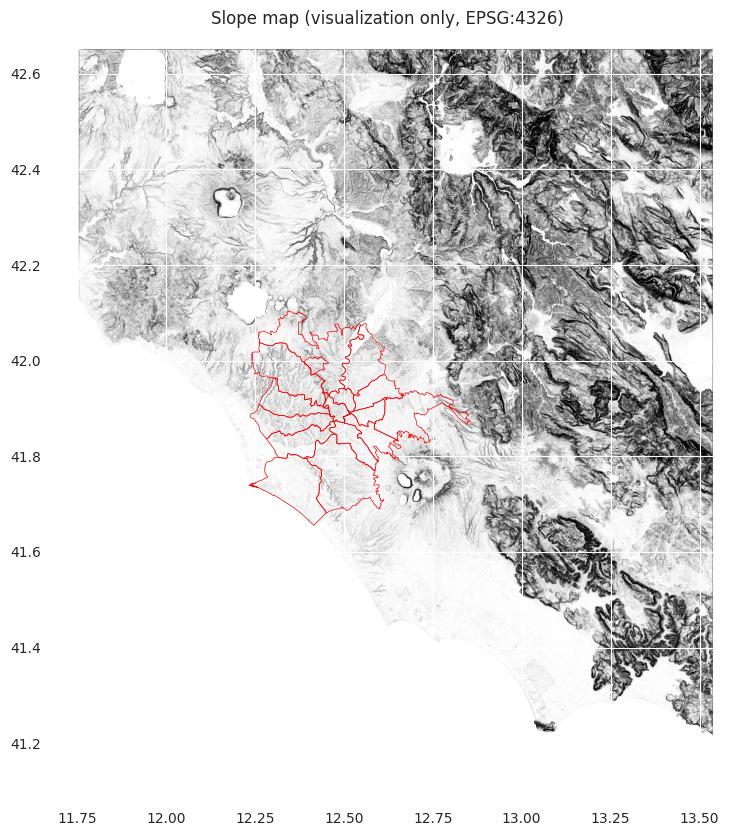

In [9]:
with rio.open(slope_4326) as src:
    slope_4326 = src.read(1)
    transform_4326 = src.transform
    
municipalities_4326 = municipalities.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))
slope_vis = np.clip(slope_4326, 0, 35) 
show(slope_vis, transform=transform_4326, ax=ax, cmap='Greys')
municipalities_4326.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
plt.title("Slope map (visualization only, EPSG:4326)")


# Save
#plt.savefig('../output/slope_x_mun.png')
plt.show()

                   name  mean_slope
0      Municipio Roma I    6.555406
1    Municipio Roma XIV    7.042030
2   Municipio Roma XIII    6.083386
3     Municipio Roma XV    5.854283
4    Municipio Roma XII    5.579827
5     Municipio Roma XI    3.994422
6     Municipio Roma IX    4.617977
7   Municipio Roma VIII    3.542147
8    Municipio Roma VII    2.727291
9    Municipio Roma III    4.895309
10    Municipio Roma IV    3.241245
11    Municipio Roma VI    4.055506
12     Municipio Roma V    2.905900
13    Municipio Roma II    5.578232
14          Giustiniana    7.667492
15     Municipio Roma X    2.562222


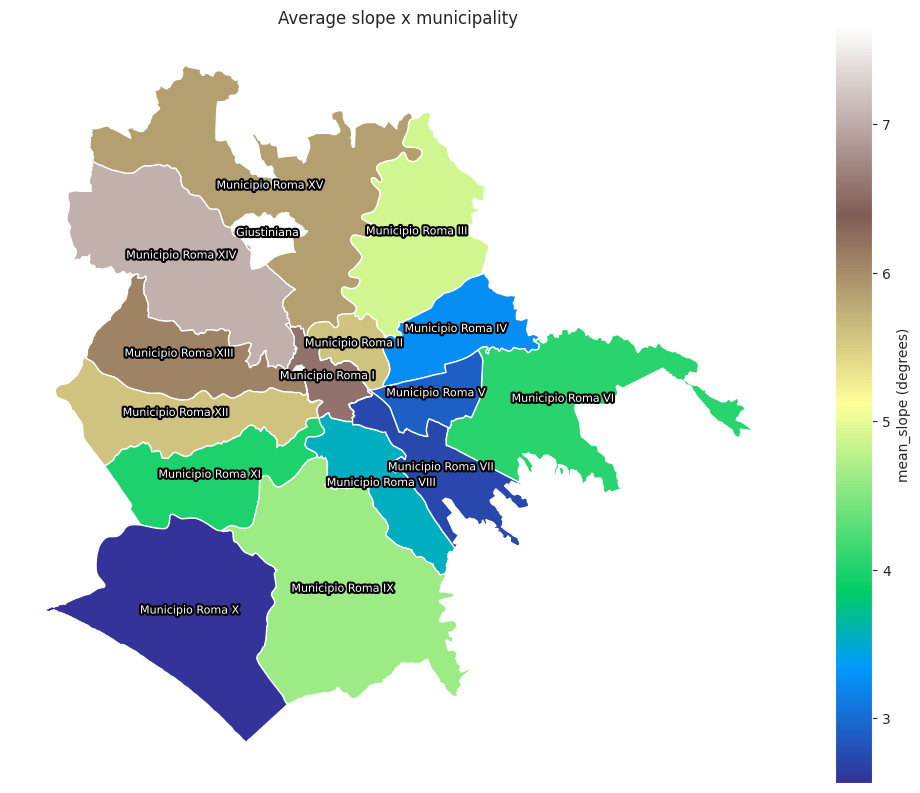

In [11]:
with rio.open(slope_25833) as src:
    slope_crs = src.crs
    slope = src.read(1)
    affine = src.transform

# Ensure municipality is in the same crs of DEM 
municipalities = municipalities.to_crs(src.crs)

# Average slope per municipality
stats = zonal_stats(municipalities, slope, affine=affine, stats=["mean"], nodata=0)

# Adding results to gdf 
municipalities["mean_slope"] = [s["mean"] for s in stats]

# Visualization
print(municipalities[['name', 'mean_slope']])

fig, ax = plt.subplots(figsize=(10, 8))

municipalities.plot(
    column='mean_slope',
    cmap='terrain',
    ax=ax,
    legend=False
)

# Colorbar
norm = mcolors.Normalize(
    vmin=municipalities['mean_slope'].min(),
    vmax=municipalities['mean_slope'].max()
)
sm = plt.cm.ScalarMappable(cmap='terrain', norm=norm)
sm._A = []

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("mean_slope (degrees)")

# Labels
for idx, row in municipalities.iterrows():
    plt.annotate(
        text=row["name"],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center',
        fontsize=8,
        color='white',
        path_effects = [
            PathEffects.withStroke(linewidth=3, foreground='black')
        ]
    )
ax.set_title("Average slope x municipality")
ax.axis('off')
plt.tight_layout()

# Save
plt.savefig('../output/ranking_slope.png')
plt.show()


According to the slope analysis, **Giustiniana shows the steepest terrain among all municipi analysed**, corroborating its position on a natural hillside and justifying the high slope values recorded.


# Walkability Composite Index

A composite walkability index was built by combining three normalized indicators: accessibility score, slope, and node density. Each indicator was min-max scaled between 0 and 1, with slope values inverted (1 - normalized slope) to reflect better walkability in flatter areas.

The final index was computed as:
walkability_index = (norm_accessibility + norm_node_density + (1 - norm_slope)) / 3

The result is a balanced index ranging from 0 (low walkability) to 1 (high walkability).


## Visualization

The index was mapped using a choropleth visualization, with municipality boundaries colored according to their composite walkability score.

A custom ranking box was added to the top-right corner of the map to highlight the top-performing municipalities:
- Title: **"Walkability Ranking"** in bold yellow font
- Index values with **two decimal digits**




In [12]:
mun = gpd.read_file("../data/15min_d/municipi_final2.gpkg")
mun['mean_slope'] = municipalities['mean_slope']

In [13]:
scaler = MinMaxScaler()

# Normalization
mun['norm_node_density'] = scaler.fit_transform(mun[['density_nodes_km2']])
mun['norm_slope'] = scaler.fit_transform(mun[['mean_slope']])

# Slope inversion because higher slope = worse walkability
mun['norm_slope_inv'] = 1 - mun['norm_slope']

# cityscore_weighted from 0/100 to 0/1
mun['norm_15min'] = mun['cityscore_weighted'] / 100

# Final index (media semplice o ponderata)
mun['walkability_index'] = (
    mun['norm_15min'] +
    mun['norm_node_density'] +
    mun['norm_slope_inv']
) / 3

print(mun['walkability_index'])


0     0.702652
1     0.117359
2     0.212784
3     0.187727
4     0.230739
5     0.358813
6     0.301972
7     0.508870
8     0.670997
9     0.274330
10    0.536344
11    0.369552
12    0.696723
13    0.664684
14    0.073404
15    0.446062
Name: walkability_index, dtype: float64


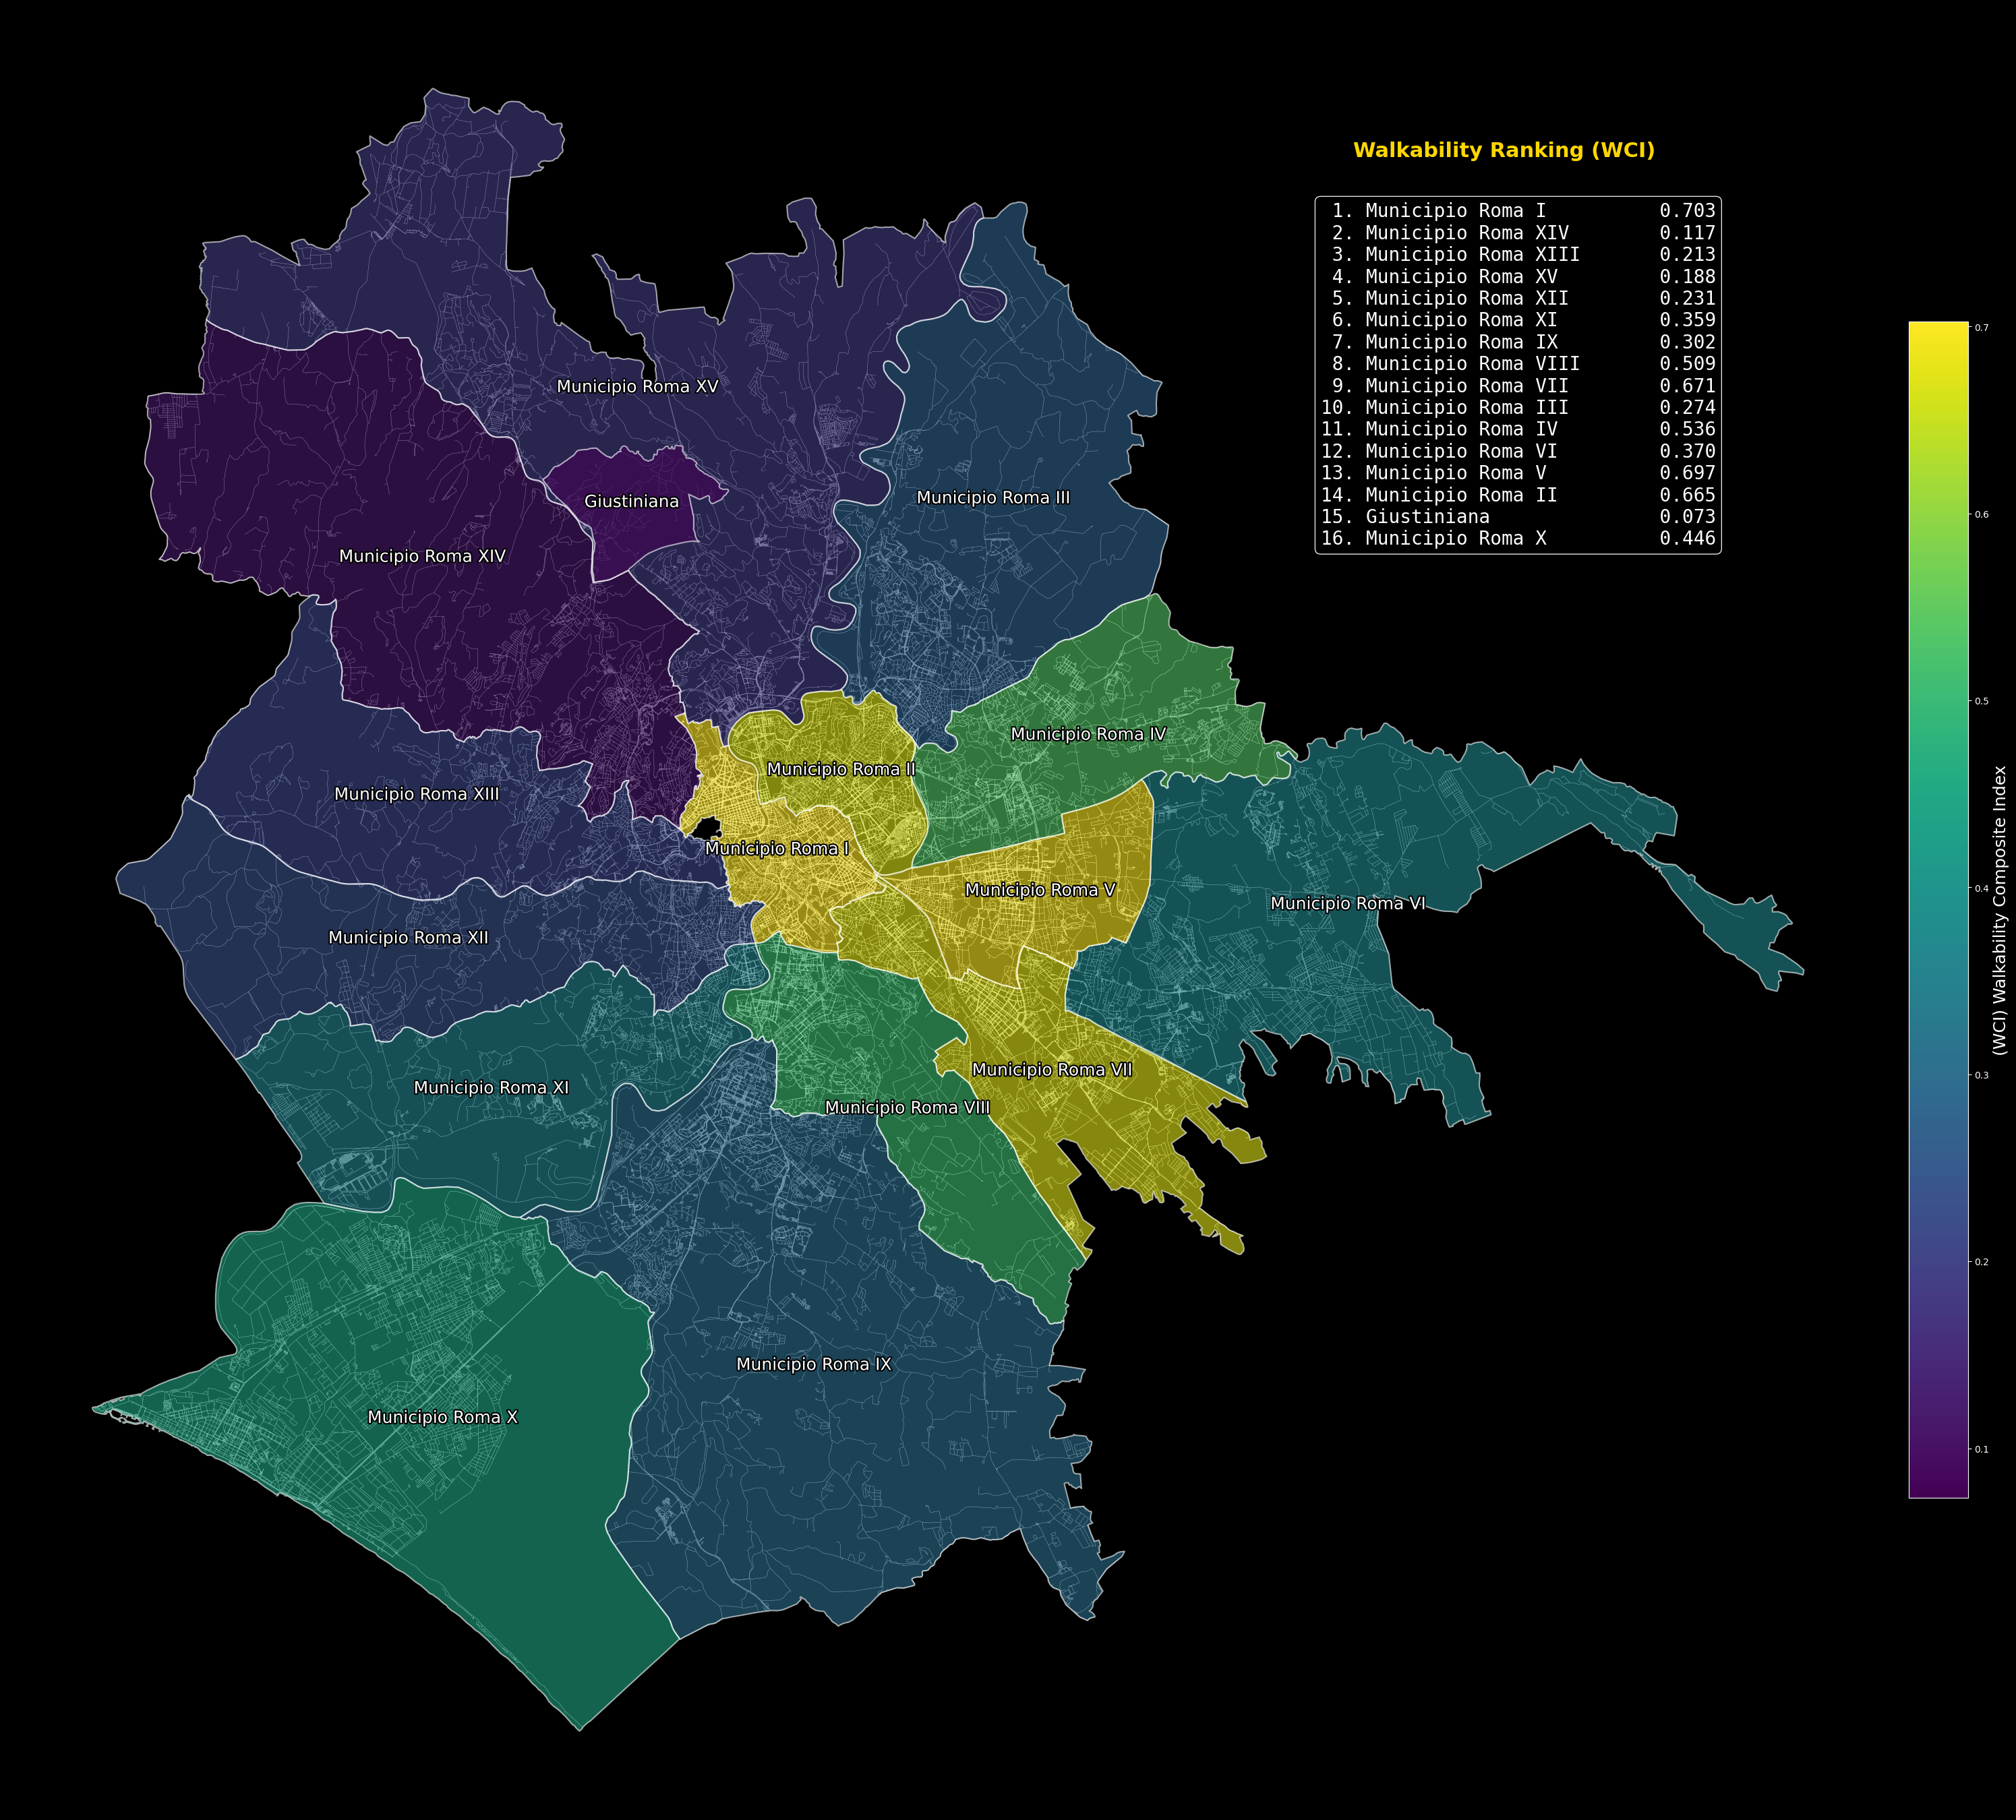

In [18]:
# Loading edges
edges_s = gpd.read_file("../data/connectivity_d/edges_s.gpkg", layer="edges")

# Normalize colormap
norm = mcolors.Normalize(
    vmin=mun['walkability_index'].min(),
    vmax=mun['walkability_index'].max()
)
cmap = plt.cm.viridis

# Plot
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')

# Roads
edges_s.plot(ax=ax, color='white', linewidth=0.2, zorder=1)


# Municipalities (choropleth, transparent fill)
mun.plot(
    ax=ax,
    column='walkability_index',
    cmap=cmap,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.6,
    zorder=3
)

# Labels
for idx, row in mun.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row['name'],
        fontsize=18,
        color='white',
        ha='center',
        va='center',
        zorder=4,
        path_effects=[
            PathEffects.withStroke(linewidth=3, foreground='black')
        ]
    )



# Ranking
# Text
ranking_text = "\n".join(
    [f"{i+1:>2}. {row['name']:<25} {row['walkability_index']:.3f}" for i, row in mun.iterrows()]
)

# Box
props = dict(boxstyle='round', facecolor='black', alpha=0.9)

# Including box with text
plt.gcf().text(
    0.85, 0.85,
    ranking_text,
    fontsize=20,
    color='white',
    verticalalignment='top',
    horizontalalignment='right',
    bbox=props,
    family='monospace'
)

# Including title
plt.gcf().text(
    0.82, 0.88,
    "Walkability Ranking (WCI)",
    fontsize=22,
    color='gold',
    fontweight='bold',
    verticalalignment='top',
    horizontalalignment='right',
    family='sans-serif'
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label('(WCI) Walkability Composite Index', fontsize=18, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.tight_layout()


# Save
#plt.savefig('../output/Boom.png')

plt.show()